# Notebook 6 – Hamilton Lane Private Assets Fund (HLPAF) Analysis

This notebook applies the unified structural model to Hamilton Lane Private Assets Fund,
using:
- reported Class R monthly returns from the fact sheet,
- portfolio composition (strategy, sector, geography, investment type),
- the SC/CS/INNOV/TAIL factor set.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.unified_model import get_structural_betas
from src.overlays import strategy_mix_overlay, sector_overlay, geography_overlay, investment_type_overlay
from src.monte_carlo import simulate_private_paths

plt.rcParams['figure.figsize'] = (8,5)


## 1. Enter HLPAF Class R Monthly Returns (from Fact Sheet)
Returns are in percent; we convert to decimal.


In [2]:
# Manually entered from Hamilton Lane Private Assets Fund fact sheet (Class R):
# Years: 2020-09 through 2025-08
data_R = {
    2020: [None, None, None, None, None, None, None, None, 0.11, 3.72, 1.52, 2.20],
    2021: [0.00, 0.27, 2.25, 1.27, 1.69, 4.82, 0.11, 2.67, 0.08, 5.12, -0.03, 2.07],
    2022: [-1.68, 0.33, 1.55, -1.36, 2.28, -0.74, 4.74, 1.60, -0.80, 3.94, 3.49, 1.14],
    2023: [2.47, 0.06, 1.19, -1.54, 0.14, 2.89, 0.54, -0.85, 1.07, 0.01, 2.19, 2.98],
    2024: [0.60, 0.90, 0.51, -0.96, 0.88, 2.18, 0.28, 1.38, 1.76, -0.53, 2.26, -0.40],
    2025: [1.58, 0.76, 1.24, 1.29, 2.57, 2.53, 0.31, -0.73, None, None, None, None],
}
rows = []
for year, vals in data_R.items():
    for m, v in enumerate(vals, start=1):
        if v is None:
            continue
        rows.append({"date": pd.Timestamp(year=year, month=m, day=28), "ret_pct": v})
df_R = pd.DataFrame(rows).sort_values("date").set_index("date")
df_R["ret"] = df_R["ret_pct"] / 100.0
df_R.tail()

,ret_pct,ret
date,,
2025-04-28,1.29,0.0129
2025-05-28,2.57,0.0257
2025-06-28,2.53,0.0253
2025-07-28,0.31,0.0031
2025-08-28,-0.73,-0.0073


### Basic Summary Statistics

In [3]:
r = df_R['ret']
mu = r.mean()
sigma = r.std()
sigma_ann = sigma * np.sqrt(12)

cum = (1 + r).cumprod()
roll_max = cum.cummax()
dd = cum / roll_max - 1
max_dd = dd.min()

print('Monthly mean:', f'{mu:.4%}')
print('Monthly vol:', f'{sigma:.4%}')
print('Annualized vol:', f'{sigma_ann:.4%}')
print('Max drawdown:', f'{max_dd:.2%}')

Monthly mean: 1.1987%
Monthly vol: 1.5698%
Annualized vol: 5.4380%
Max drawdown: -1.68%


### Plot Monthly Returns and Cumulative NAV

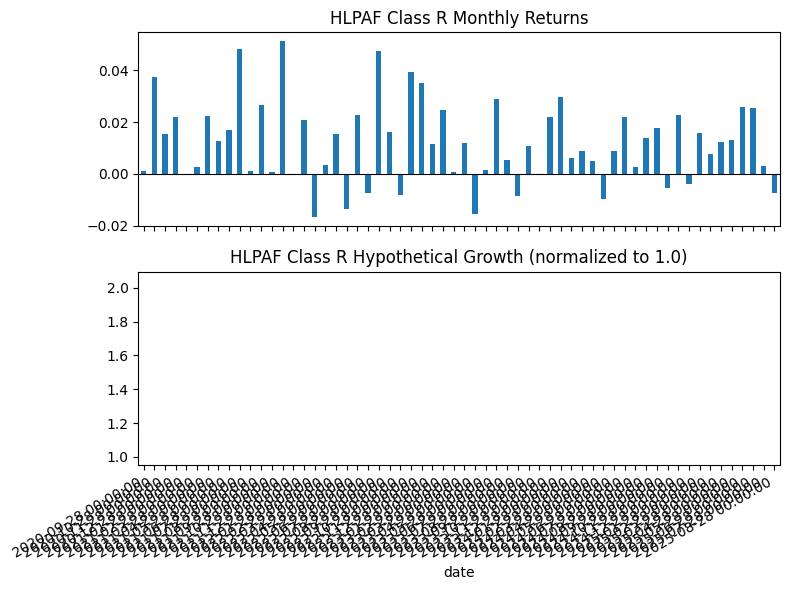

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
r.plot(ax=ax[0], kind='bar')
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].set_title('HLPAF Class R Monthly Returns')

cum.plot(ax=ax[1])
ax[1].set_title('HLPAF Class R Hypothetical Growth (normalized to 1.0)')
plt.tight_layout()
plt.show()

## 2. Desmoothing via AR(1)
Estimate AR(1) and construct an "unsmoothed" return series.


In [5]:
phi = r.autocorr(lag=1)
r_lag = r.shift(1)
r_unsm = (r - phi * r_lag) / (1 - phi)
r_unsm = r_unsm.dropna()

mu_unsm = r_unsm.mean()
sigma_unsm = r_unsm.std()
sigma_unsm_ann = sigma_unsm * np.sqrt(12)

print('AR(1) phi:', phi)
print('Desmoothed monthly mean:', f'{mu_unsm:.4%}')
print('Desmoothed monthly vol:', f'{sigma_unsm:.4%}')
print('Desmoothed annualized vol:', f'{sigma_unsm_ann:.4%}')

AR(1) phi: -0.22169817534930733
Desmoothed monthly mean: 1.2197%
Desmoothed monthly vol: 1.2585%
Desmoothed annualized vol: 4.3595%


### Compare original vs desmoothed distributions

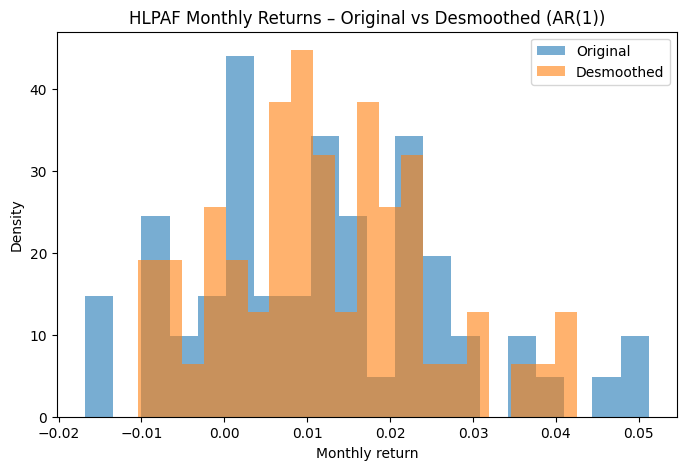

In [6]:
plt.figure(figsize=(8,5))
plt.hist(r.dropna(), bins=20, alpha=0.6, density=True, label='Original')
plt.hist(r_unsm.dropna(), bins=20, alpha=0.6, density=True, label='Desmoothed')
plt.legend()
plt.title('HLPAF Monthly Returns – Original vs Desmoothed (AR(1))')
plt.xlabel('Monthly return')
plt.ylabel('Density')
plt.show()

## 3. Build HLPAF Structural Betas via Overlays
Use unified structural betas and overlay functions.


In [7]:
# Structural betas for pure Buyout and pure VC
betas_bo = get_structural_betas('buyout')
betas_vc = get_structural_betas('vc')
print('Buyout betas:\n', betas_bo)
print('\nVC betas:\n', betas_vc)

Buyout betas:
 SC       1.5
CS       0.8
INNOV    0.1
TAIL     1.2
dtype: float64

VC betas:
 SC       1.2
CS       0.4
INNOV    1.1
TAIL     2.0
dtype: float64


### 3.1 Strategy Mix Overlay (Buyout / VC)


In [8]:
# Map HLPAF strategy weights into Buyout vs VC weights
# Buyout 79%, Growth 11%, Venture 7%, Credit 3%.
# Treat Growth as 70% Buyout / 30% VC, Credit as 80% Buyout / 20% VC.
w_bo = 0.79 + 0.11*0.7 + 0.03*0.8
w_vc = 0.07 + 0.11*0.3 + 0.03*0.2
print('Effective Buyout weight:', w_bo)
print('Effective VC weight:', w_vc)

betas_mix = strategy_mix_overlay(betas_bo, betas_vc, w_buyout=w_bo, w_vc=w_vc)
print('\nStrategy-mix betas (HLPAF base):\n', betas_mix)

Effective Buyout weight: 0.891
Effective VC weight: 0.10900000000000001

Strategy-mix betas (HLPAF base):
 SC       1.4673
CS       0.7564
INNOV    0.2090
TAIL     1.2872
dtype: float64


### 3.2 Sector Overlay (29% Tech)


In [9]:
tech_weight = 0.29
betas_sector = sector_overlay(betas_mix, tech_weight=tech_weight)
print('After sector (tech) overlay:\n', betas_sector)

After sector (tech) overlay:
 SC       1.467300
CS       0.756400
INNOV    0.411033
TAIL     1.909347
dtype: float64


### 3.3 Geography Overlay (71% NA, 22% EU, 3% APAC, 4% ROW)


In [10]:
betas_geo = geography_overlay(betas_sector,
                              na_weight=0.71,
                              eu_weight=0.22,
                              apac_weight=0.03,
                              row_weight=0.04)
print('After geography overlay:\n', betas_geo)

After geography overlay:
 SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     1.909347
dtype: float64


### 3.4 Investment Type Overlay (co-invest & GP-led concentration)


In [11]:
# Co-invest + single-asset + structured ≈ 49% + 12% + 12% = 73%
# Multi-asset secondary + diversified LP-led ≈ 11% + 16% = 27%
# Use a high concentration level, e.g. 0.7 on [0,1].
betas_hl = investment_type_overlay(betas_geo, concentration_level=0.7)
print('Final HLPAF structural betas:\n', betas_hl)

Final HLPAF structural betas:
 SC       1.633105
CS       0.756400
INNOV    0.411033
TAIL     3.245889
dtype: float64


## 4. Regress HLPAF Desmoothed Returns on Factors (Optional)
This assumes you have built real factors (SC, CS, INNOV, TAIL) as `factors_real`.


In [12]:
import statsmodels.api as sm

# Example: align factors_real (from Notebook 3) with r_unsm
# factors_real should have columns ['SC','CS','INNOV','TAIL'] at monthly frequency.

# from some_path import factors_real  # user: load your factor DataFrame here
# For illustration, we create a placeholder with NaNs:
factors_real = pd.DataFrame(index=r_unsm.index, columns=['SC','CS','INNOV','TAIL'])

# Replace the above with your real factors before running the regression.
df_reg = pd.concat([r_unsm.rename('HLPAF'), factors_real], axis=1).dropna()
if not df_reg.empty:
    X = sm.add_constant(df_reg[['SC','CS','INNOV','TAIL']])
    y = df_reg['HLPAF']
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print('No overlapping data between HLPAF returns and factors_real; load real factor data to run regression.')

No overlapping data between HLPAF returns and factors_real; load real factor data to run regression.


## 5. Compare HLPAF vs S&P 500 in Factor Space


In [13]:
df_reg

,HLPAF,SC,CS,INNOV,TAIL
date,,,,,


In [14]:
factors_real

,SC,CS,INNOV,TAIL
date,,,,
2020-10-28,NaN,NaN,NaN,NaN
2020-11-28,NaN,NaN,NaN,NaN
2020-12-28,NaN,NaN,NaN,NaN
2021-01-28,NaN,NaN,NaN,NaN
2021-02-28,NaN,NaN,NaN,NaN
2021-03-28,NaN,NaN,NaN,NaN
2021-04-28,NaN,NaN,NaN,NaN
2021-05-28,NaN,NaN,NaN,NaN
2021-06-28,NaN,NaN,NaN,NaN


In [15]:
import yfinance as yf

# Download S&P 500 proxy (SPY) and build monthly log-returns
#spy = yf.download('SPY', start='2005-01-01', auto_adjust=True, progress=False)['Adj Close']
spy = yf.download('SPY', start='2005-01-01', auto_adjust=True, progress=False)['Close']
spy_m = spy.resample('ME').last().pct_change().dropna()
spy_m.name = 'SPY'

# Align SPY with factors_real
df_spy = pd.concat([spy_m, factors_real], axis=1).dropna()
if not df_spy.empty:
    X_sp = sm.add_constant(df_spy[['SC','CS','INNOV','TAIL']])
    y_sp = df_spy['SPY']
    model_sp = sm.OLS(y_sp, X_sp).fit()
    print(model_sp.summary())
    betas_sp = model_sp.params[['SC','CS','INNOV','TAIL']]
    print('\nS&P 500 factor betas (SPY):\n', betas_sp)
else:
    print('No overlapping data between SPY and factors_real; load real factor data first.')

No overlapping data between SPY and factors_real; load real factor data first.


## 6. Monte Carlo Comparison – HLPAF vs S&P 500
Using the estimated/structural betas, simulate distributions and compare VaR/CVaR.


In [16]:
from src.monte_carlo import simulate_factors_normal

# Here we assume factors_real is filled with real data
if factors_real.dropna().shape[0] > 24:
    factors_hist = factors_real.dropna()
    betas_sp = betas_sp  # from regression above

    # Simulate factor paths
    rng = np.random.default_rng(123)
    n_paths = 10000
    n_steps = 60  # e.g. 5 years of monthly steps
    sims_F = simulate_factors_normal(factors_hist, n_paths=n_paths, n_steps=n_steps, rng=rng)

    from src.unified_model import FACTOR_ORDER

    # Map factors to returns for HLPAF and SPY
    k = len(FACTOR_ORDER)
    beta_hl_vec = betas_hl.reindex(FACTOR_ORDER).values.reshape(k,1)
    beta_sp_vec = betas_sp.reindex(FACTOR_ORDER).values.reshape(k,1)

    mean_hl = sims_F @ beta_hl_vec
    mean_sp = sims_F @ beta_sp_vec

    # Optionally add idiosyncratic risk
    eps_hl = rng.normal(0.0, 0.02, size=mean_hl.shape)  # tune as needed
    eps_sp = rng.normal(0.0, 0.02, size=mean_sp.shape)

    r_hl = (mean_hl + eps_hl).squeeze(-1)
    r_sp = (mean_sp + eps_sp).squeeze(-1)

    cum_hl = (1 + r_hl).prod(axis=1) - 1
    cum_sp = (1 + r_sp).prod(axis=1) - 1

    def var_cvar(series, alpha=0.05):
        q = np.quantile(series, alpha)
        cvar = series[series <= q].mean()
        return q, cvar

    for name, series in [('HLPAF', cum_hl), ('S&P 500', cum_sp)]:
        print(f'--- {name} ---')
        for a in [0.10, 0.05, 0.01]:
            v, c = var_cvar(series, a)
            print(f'alpha={a}: VaR={v:.2%}, CVaR={c:.2%}')

    # Plot comparison
    plt.figure(figsize=(8,5))
    plt.hist(cum_hl, bins=50, alpha=0.5, density=True, label='HLPAF')
    plt.hist(cum_sp, bins=50, alpha=0.5, density=True, label='S&P 500')
    plt.xlabel('Cumulative return over horizon')
    plt.ylabel('Density')
    plt.title('Simulated 5-year cumulative returns – HLPAF vs S&P 500')
    plt.legend()
    plt.show()
else:
    print('Need sufficient real factor history in factors_real to run Monte Carlo comparison.')

Need sufficient real factor history in factors_real to run Monte Carlo comparison.
